#Лайт задание

В алгоритме актёр-критик появляется один по-факту скрытый гиперпараметр: это разница между скорости обучения актёра и критика. В лекционном ноутбуке, скорость обучения критика в 2 раза быстрее, чем актёра.

В этом задании, нужно взять шаблон ноутбука `Преймущественный актёр-критик с тензорфлоу`. Нужно провести несколько экспериментов:

1. Обучите алгоритм чтобы скорость обучения критика была равна скоростью обучения актёра
2. Обучите алгоритм чтобы скорость обучения критика была в 10 раз выше скоростью обучения актёра
3. Добавьте слои регуляризации (`Dropout()` либо `SpatialDropout2D()`) в нейронную сеть
4. Добавьте слои нормализации (`LayerNormalization()` либо `BatchNormalization()`) в нейронную сеть


#Базовый код из лекции

In [ ]:
%%bash
#%%bash - значит используем командную строку (не код питона)
# Устанавливаем нужные программы, которая требует от нас документация: https://github.com/mwydmuch/ViZDoom/blob/master/doc/Building.md#-linux

apt-get update

apt-get install build-essential zlib1g-dev libsdl2-dev libjpeg-dev \
nasm tar libbz2-dev libgtk2.0-dev cmake git libfluidsynth-dev libgme-dev \
libopenal-dev timidity libwildmidi-dev unzip

# Устанавливаем библиотеку Boost
apt-get install libboost-all-dev

# Устанавливаем зависимости Lua
apt-get install liblua5.1-dev

Get:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:3 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:6 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Get:7 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Hit:8 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:9 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:11 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:13 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Get:14 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Get:15 http://ppa

Подключаемся к диску и импортируем все нужные модули и библиотеки.

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


Устанавливаем VizDoom.

In [ ]:
!pip install vizdoom==1.1.9

     |████████████████████████████████| 15.0 MB 8.5 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
  Created wheel for vizdoom: filename=vizdoom-1.1.9-py3-none-any.whl size=14084060 sha256=52face9239dc0e04332b68b45c5a18ec40ca829bdd36cb9a23d79aaa3d837f65
  Stored in directory: /root/.cache/pip/wheels/89/75/34/2c03a5cc9d572ad08bed39e67bf0da279f63b03864a3aa2c66
Successfully built vizdoom


Сначала, скачиваем все нужные файлы для ViZDoom.

In [ ]:
import gdown #Импортируем модуль для скачивания датасетов

#Скачиваем файлы для ViZDoom
gdown.download('https://storage.googleapis.com/datasets_ai/Advanced/6_RL/rl.zip', output = None, quiet = True)
!unzip -qo rl.zip -d /content/ViZDoom/ #Разархивируем файлы

In [ ]:
from vizdoom import *         #Импортируем все функции из cреды ViZDoom
import tensorflow as tf       #Библиотека тензорфлоу
import numpy as np            #Библиотека numpy
import random                 #Импортируем модуль для генерации рандомных значений
import pickle                 #Модуль для сохранения результатов в файл
import cv2                    #Модуль для работы с картинками и видео (нужно для предобработки данных и записи результата)
import time                   #Модуль который используем чтобы засекать время выполнения кода

#Импортируем тип данных deque из встроенного модуля питона
from collections import deque   #deque - это список где автоматический удаляются старые значения при добовлении новых, чтобы не было переполнение памяти.
import matplotlib.pyplot as plt #Импортируем модуль pyplot из бибиотеки matplotlib

from tensorflow.keras.models import load_model, Model, Sequential #Импортируем функции для создания и загрузки модели из тензорфлоу
from tensorflow.keras.layers import *                             #Импортируем все слои из кераса
from tensorflow.keras.optimizers import RMSprop                   #Импортируем оптимизатор RMSprop
from tensorflow.keras import backend as K                         #Импортируем модуль для бэкэнда кераса
from tensorflow.keras.utils import to_categorical                 #Импортируем функцию для удобного onehot энкодинга
from moviepy.editor import *                                      #Импортируем полезные функции из библиотеки для возпроизведение видео с результатом
from google.colab import output                                   #Импортируем функцию для управления вывода в колаб-ячейках

Imageio: 'ffmpeg-linux64-v3.3.1' was not found on your computer; downloading it now.
Try 1. Download from https://github.com/imageio/imageio-binaries/raw/master/ffmpeg/ffmpeg-linux64-v3.3.1 (43.8 MB)
Downloading: 8192/45929032 bytes (0.0%)1482752/45929032 bytes (3.2%)3424256/45929032 bytes (7.5%)5488640/45929032 bytes (12.0%)7626752/45929032 bytes (16.6%)10043392/45929032 bytes (21.9%)12009472/45929032 bytes (26.1%)14114816/45929032 bytes (30.7%)16400384/45929032 bytes (35.7%)19300352/45929032 bytes (42.0%)22175744/45929032 bytes (48.3%)24207360/45929032 bytes (52.7%)26378240/45929032 bytes (57.4%)295

## Создание архитектуры нейросетей

Начнем сразу с самого важного и интересного - на этот раз, у нас будет не одна нейросеть в которой отдельно содержиться и актёр и критик, а две разные нейросети (актёр и критик соответственно).

Также, мы будем создавать эти модели не привычным нам методом, через Functional API Кераса, а через ООП. Начиная с этого занятия, мы погрузимся в более базовый фреймворк Тензорфлоу - это делается, потому что нейронная сеть сможет значительно быстрее обучаться, если мы будем использовать не Керас а более чистый тензорфлоу.

Ещё один плюс такого подхода заключается в том, что у нас появляется огромное количество дополнительных возможностей при инференсе - ведь мы по сути пишем логику инференса сами. Но именно эти плюсы мы скорее увидем позже, на дпугих занятиях.

А нижепредставленным коде, мы создаем класс через которого будем строить модель для актёра и критика отдельно. Важно отметить, что актёр и критик будут отдельными моделями, и по идеи можно использовать два отдельных класса для создания этих моделей. Однако, в нашем примере этого алгоритма, все скрытые слои обеих моделей будут одинаковыми - лишь выходные слои будут разными. По этому, мы сможем создать обе модели используя один класс. 

In [ ]:
#Создаем класс, через который будем создавать модель артёка и модель критика
#Инициализатор класса принимает на вход лишь один параметр - количество возможных действий в среде.
#Если этот параметр не задается, его значение по умолчанию будет None, что обозначает этот класс будет создавать не модель актёра, а модель критика.

class Actor_Critic(tf.keras.Model):       #Класс наследует все методы из класса tf.keras.Model - это обязательно!!!
  def __init__(self, is_actor = True):
    super().__init__()  #В первой строке при инициазизации класса нужно указать эту команду, чтобы инициализировать наследственный класс. Иначе класс не будет работать!
    self.conv_1 = Conv2D(32, 4, strides=(2, 2), activation='relu')   #Создаем первый свёрточный слой
    self.conv_2 = Conv2D(64, 3, strides=(2, 2), activation='relu')   #Создаем второй свёрточный слой
    self.conv_3 = Conv2D(128, 3, strides=(2, 2), activation='relu')  #Создаем третий свёрточный слой
    self.conv_4 = Conv2D(256, 3, strides=(2, 2), activation='relu')  #Создаем третий свёрточный слой
    self.conv_5 = Conv2D(512, 3, strides=(2, 2), activation='relu')  #Создаем третий свёрточный слой
    self.reduce_dimension = GlobalMaxPooling2D()                     #Создаем слой для снижения размерности
    self.concatenate = Concatenate()                                 #Создаем слой конкатенации (позже объясним, зачем он нужен и как используется)
    self.dense = Dense(512, activation = 'relu')                     #Создаем второй полносвязанный слой
    if is_actor:   #Если параметр is_actor имеет соответствующее значение, мы создаем актёра.
      self.output_layer = Dense(action_size, activation = 'softmax') #Соответственно, создаем полносвязанный выходной слой с action_size количество нейронов (action_size это количество уникальных действий в среде).
    else:             #Иначе:
      self.output_layer = Dense(1) #Создаем выходной слой с 1 нейроном и линейной активационной функцией (т.е. создаем критика)
        
  #Также, нам необходимо создать метод для вызова класса. Этот метод содержит прямой проход нейронной сети,
  #то есть именно в этом методе мы определяем как слои связанны между друг-другом и как они обрабатывают данные.
  #Функция вызова принимает на вход два параметра, потому что у нейронной сети действительно будет два входа - оба которые будут принимать данные из игровой среды   
  def __call__(self, input_1, input_2):
    x = self.conv_1(input_1)     #Первый вход будет принимать массив последовательных кадров из игровой среды (как это делалось раньше) - подается в первый свёрточный слой.
    x = self.conv_2(x)           #Выходной массив первого слоя подается на второй свёрточный слой    
    x = self.conv_3(x)           #Выходной массив второго слоя подается на третий свёрточный слой   
    x = self.conv_4(x)           #Выходной массив второго слоя подается на третий свёрточный слой   
    x = self.conv_5(x)           #Выходной массив второго слоя подается на третий свёрточный слой 
    x = self.reduce_dimension(x) #Выходной массив пятого слоя подается на выравнивающий слой 
    x = self.concatenate([x, input_2])  #Дальше делаем конкатенацию выравнивающего слоя (который содержит фичи, которые извлекли свёртки) с вторым входом, на который мы будем подавать игровые данные из среды (текущее здоровье игрока).
    x = self.dense(x)            #Результат конкатенации подаем на полносвзязанный слой
    output_data = self.output_layer(x) #Выход второго полносвязанного слоя подаем на последний слой нейронной сети (action_size нейронов если это актёр, иначе 1 нейрон)
    return output_data   #Возвращаем результат обработки нейронной сети

Важно отметить, что нам совсем не обязательно использовать несколько входных слоев в этой нейронной сети. Это всего лишь выбор, но в нём есть смысл т.к. мы подаем и трёхмерный массив изображений, и одномерный вектор с игровыми данными  на вход НС.

##Зачем использовать Тензорфлоу? - Проведем эсперимент

Чтобы проверить, действительно ли Тензорфлоу-модели быстрее чем Керасовские, мы создадим ту же модель на Керасе и Тензорфлоу. Затем, мы засечем время, которое требуется для обеих моделей чтобы сделать инференс 1000 раз.

Сначала, создать модель в Керасе, которая такая же по архитектуре как класс модели выше.

In [ ]:
action_size = 3 #Задаем количество нейронов на выходе модели

input_layer_1 = Input((96, 96, 1)) #Создаем первый входной слой
input_layer_2 = Input((1,))        #Создаем второй входной слой
conv_1 = Conv2D(32, 4, strides=(2, 2), activation='relu')(input_layer_1) #Первый сверточный слой
conv_2 = Conv2D(64, 3, strides=(2, 2), activation='relu')(conv_1)        #Второй сверточный слой
conv_3 = Conv2D(128, 3, strides=(2, 2), activation='relu')(conv_2)       #Третий сверточный слой
conv_4 = Conv2D(256, 3, strides=(2, 2), activation='relu')(conv_2)       #Третий сверточный слой
conv_5 = Conv2D(512, 3, strides=(2, 2), activation='relu')(conv_2)       #Третий сверточный слой
reduce_dimension = GlobalMaxPooling2D()(conv_5) #Cлой для снижения размерности
concatenate_layer = Concatenate()([reduce_dimension, input_layer_2]) #Слой конкатенации выравнивающего слоя и второго входного слоя
dense = Dense(512, activation = 'relu')(concatenate_layer)  #Полносвязанный слой
output_layer = Dense(action_size)(dense) #Выходной слой

keras_model = Model([input_layer_1, input_layer_2], output_layer) #Создаем модель кераса

Также создадим эту модель через тензорфлоу - для этого лишь нужно вызвать класс актёра-критика.

In [ ]:
tensorflow_model = Actor_Critic() #Создаем модель актёра-критика в тензорфлоу (она одинаковая по архитектуре, что керасовская модель выше).

Проверим, сколько времени требуется Керасовской модели чтобы провести инференс на произвольных данных 1000 раз.

In [ ]:
input_data = [np.zeros((1, 96, 96, 1)), np.zeros((1, 1))]         #Создаем список входных данных (два массива нулей)
start = time.time()                                               #Засекаем время в начале выполнения кода
for i in range(1000):                                             #Инициализируем цикл, который будет прогоняться 1000 раз
  keras_model.predict(input_data)                                 #Проводим инференс
end = time.time()                                                 #Засекаем время в конце выполнения кода
print(f"Время выполнения кода: {round(end - start, 2)} секунд.")  #Смотрим сколько время потребовалось

Время выполнения кода: 67.98 секунд.


Требуется примерно 40 секунд, чтобы выполнить этот код. Это достаточно долго.

Давайте теперь проверим скорость выполнения инференса на модели из тензорфлоу.

In [ ]:
input_data_1, input_data_2 = np.zeros((1, 96, 96, 1)), np.zeros((1, 1))         #Создадим два отдельных параметра, которые соответствуют входным данным (два массива нулей)
start = time.time()                                                             #Засекаем время в начале выполнения кода
for i in range(1000):                                                           #Инициализируем цикл, который будет прогоняться 1000 раз
  tensorflow_model(input_data_1, input_data_2)                                  #Проводим инференс (для этого лишь нужно вызвать модель, если она построена на тензорфлоу)
end = time.time()                                                               #Засекаем время в конце выполнения кода
print(f"Время выполнения кода: {round(end - start, 2)} секунд.")                #Смотрим сколько время потребовалось

Время выполнения кода: 8.48 секунд.


Как мы видим, модель построена на тензорфлоу выполняет тот же инференс почти в десяток раз быстрее (причём если нейросеть была легче и проще, этот показатель был бы больше чем в 10 раз). Стоит отметить, что этот эффект более всего очевиден когда мы повторно проводим инференс на небольших тензорах с одним элементом (что как раз часто и делается в обучении с подкреплением) - если использовать большие датасеты, эта разница становиться незначительной.

Дело в том, что модель кераса выполняет кучу постороннего кода перед самим инференсом - и если мы проводим инференс 1000 раз по отдельности, этот посторонний код также будет выполняться 1000 раз. Это сильно замедляет время выполнения кода в обучении с подкреплением.

## Создаем модели актёра и критика

In [ ]:
game = DoomGame() #Инициализируем среду
game.load_config("/content/ViZDoom/scenarios/health_gathering.cfg") #Загружаем сценарий "сбор здоровия"
game.set_screen_resolution(ScreenResolution.RES_160X120) #Устанавливаем размер кадров среды (лучше использовать 160 х 120 чтобы игра прогонялась быстрее)
game.set_window_visible(False) #Нужно отключить окно чтобы не было ошибки
game.init() #Инициализируем игру

action_size = game.get_available_buttons_size()  #Извлекаем количество возможных уникальных действий
len_agent_state = len(game.get_state().game_variables)  #Извлекаем количество переменных (длину вектора) описывающих среду - это понадобиться чуть позже

actor_model = Actor_Critic(is_actor = True)   #Создаем объект модели актёра
critic_model = Actor_Critic(is_actor = False) #Создаем объект модели критика

## Создание функции обучения

В данном примере, мы не можем использовать model.fit() или model.train_on_batch() для обучения модели, но сколько мы используем собственный класс модели. Нам нужно обучать модели также, как это происходит на базовом тензорфлоу - для этого мы начнем с создания функций, которые будут возвращать ошибку для актёра и для критика.

In [ ]:
#Создаем функцию для подсчета ошибки предсказания актёра.
#Функция принимает на вход две части состояния по которым совершается предсказания, действия совершенны в игровой среде, и преймущества которые подсчитываются с помощью критика
def calculate_actor_loss(environment_states, agent_states, actions, advantages):
    actor_probabilities = actor_model(environment_states, agent_states)  #Подаем две отдельные части состояния на вход нейронной сети, чтобы получить вероятности действий

    cce = tf.keras.losses.CategoricalCrossentropy() #В качестве ошибки используем категориальную кросс-энтропию
    actor_loss = cce(actions, actor_probabilities, sample_weight = advantages) #Считаем кросс-энтропию, используем преймущества в качестве весов сэмплирования
    
    #Добавляем небольшую ошибку энтропии - таким образом, агент получает наказание за слишком большую уверенность в действии 
    #это позволяет алгоритму лучше исследовать среду и не переобучаться - без этого элемента возможно что ничего в принцине не получиться
    entropy_loss = 0.01 * tf.reduce_mean(actions * tf.math.log(actor_probabilities)) 
    return actor_loss + entropy_loss #Возвращаем сумму двух ошибок

#Создаем функцию для подсчета ошибки критика.
#Функция принимает на вход две части состояния по которым совершается предсказания, и награды из игровой среды
def calculate_critic_loss(environment_states, agent_states, rewards):
    values = critic_model(environment_states, agent_states) #Подаем две отдельные части состояния на вход нейронной сети, чтобы получить предсказанную награду
    critic_loss = tf.keras.losses.MSE(rewards, values) #Считаем MSE с всех значений - сначала просто считаем квадратную ошибку для каждого примера отдельно, затем берём среднее
    return critic_loss, values #Возвращаем скалярное значение ошибки

Далее, мы создаем функцию внутри которой будет происходить само обучение. Эта функция будет вызовать ранее написенные функции для подсчета значения ошибки.

In [ ]:
#Функция для обучения алгоритма в библиотеке тензорфлоу
#принимает на вход две составные части состояния, действия, и награды из игровой среды.
def train(episode_environment_states, episode_agent_states, episode_actions, episode_rewards):
    episode_environment_states = tf.convert_to_tensor(episode_environment_states, dtype = tf.float32) #Сначала, нам нужно конвертировать все numpy-массивы в tensorflow-тензовы - конвертируем изображения в тензоры
    episode_agent_states  = tf.convert_to_tensor(episode_agent_states, dtype = tf.float32)  #Конвертируем векторы состояний в тензоры
    episode_actions = tf.one_hot(episode_actions, action_size, dtype = tf.float32)        #Конвертируем действия в тензоры и приводим в onehot кодирование.
    episode_rewards = preprocess_rewards(episode_rewards) #Обрабатываем награды также как это делалось в первом уроке по градиентной политике (функция preprocess_rewards объявляется позже) - функция автоматический конвертирует в тензор.

    with tf.GradientTape() as tape: #Дальше нужно использовать GradientTape() чтобы посчитать значение ошибки
        critic_loss, values = calculate_critic_loss(episode_environment_states, episode_agent_states, episode_rewards) #Считаем ошибку критика используя ранее заданную функцию
    critic_gradients = tape.gradient(critic_loss, critic_model.trainable_variables)           #Используем значение ошибки чтобы подсчитать градиенты
    critic_optimizer.apply_gradients(zip(critic_gradients, critic_model.trainable_variables)) #Проводим обучение - применяем градиенты к обучаемым параметрам модели критика
    
    episode_advantages = episode_rewards - values.numpy().flatten()  #Считаем преймущества - предсказанные значения - настоящие, переводим результат в numpy-массив
    
    with tf.GradientTape() as tape: #Делаем то же самое с моделию актёра - используем GradientTape() чтобы посчитать значение ошибки
        actor_loss = calculate_actor_loss(episode_environment_states, episode_agent_states, episode_actions, episode_advantages) #Считаем ошибку актёра используя ранее заданную функцию
    actor_gradients = tape.gradient(actor_loss, actor_model.trainable_variables)              #Используем значение ошибки чтобы подсчитать градиенты
    actor_optimizer.apply_gradients(zip(actor_gradients, actor_model.trainable_variables))    #Проводим обучение - применяем градиенты к обучаемым параметрам модели актёра

##Прочие функции/код

Дальше идут уже знакомые полезные функции и код для инициализации среды. Начнём с созданием функции для предобработки наград - единственное отличие этой функции от той же функции для предобработки **непрерывных** наград из первого занятия по градиентной политике заключается в том, что эта функция возвращает результат в виде тензора.

In [ ]:
#Функция для предобработки наград
def preprocess_rewards(rewards):
  processed_rewards = np.zeros_like(rewards, dtype = np.float32) #Сначала создаем массив из нулей с той же размерностью, как в массиве наград 
  running_add = 0 #Переменная которая используется для предобработки наград
  for i in reversed(range(0, len(rewards))): #В цикле итерируем через индексы списка наград в обратном порядке
    running_add = running_add * gamma + rewards[i] # Составляем новую награду, в соответствии с "псевдо"-уравнением Бэллмена
    processed_rewards[i] = running_add #Записываем награду в ранее созданный массив
  return processed_rewards #Возвращаем массив наград

Также нужно не забыть создать функцию которая будет назначать награды.

In [ ]:
#Функция назначения наград - принимает на вход статистику из предыдущего и текущего состояния, а также булевое значение которое сообщает если эпизод закончился
def get_reward(previous_agent_state, current_agent_state, episode_done, timestep):
  reward = 0 #Инициализируем награду как 0
  #Нужно отметить что эпизод не может длиться дольше чем 2100 кадров, даже если агент выживает 
  #По этому если агент продержался до этого момента, мы не штрафцем за завершение эпизода.
  if episode_done and timestep < 2100: 
    reward -= 1 #Если эпизод завершился преждевременно (агент умер), агент получает награду -1
  elif current_agent_state[0] > previous_agent_state[0]: #Если здоровие выше, чем в предыдущем моменте (агент взял аптечку)
    reward += (current_agent_state[0] - previous_agent_state[0])/50 #Назначаем награду в соответствии с добавленным здоровием.

  return reward  #Возвращаем подсчитанную награду

Следующая функция предобрабатывает кадр, меняя размер кадра и превращая кадр в черно-белый.

In [ ]:
#Создаем функцию для предобработки кадра (сжимаем размер изобрадения до 64 х 64 и превращаем в черно-белый цвет).
def preprocess_frame(frame):
  frame = np.rollaxis(frame, 0, 3) #Сначала нужно предобрадотать картинку чтобы размер поменялся с (3, width, height) на (width, height, 3).
  frame = cv2.resize(frame, (image_width, image_height), interpolation=cv2.INTER_CUBIC) #Меняем размерность картинки на (64 х 64)
  frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY) #Делаем изображение чёрно-белым

  return frame.reshape(image_width, image_height, -1)/255 #Делаем решейп, и возврашаем предобработанную картинку, нормализуем

Следующая функция очень простая - она предобрабатывает числа из **состояния агента**, чтобы они были нормированными.

In [ ]:
#Функция для предобработки прочих чисел из игровой среды
def preprocess_agent_state(agent_state):
  return agent_state/50 - 1  #Просто делим на 50 и вычитать 1, чтобы они не имели слишком большую величину

Также, создаем функцию для выбора действия по заданному состоянию. Данная функция будет использовать только актёра, по скольку именно актёр принимает на вход состояния и возвращает нужное действие (критик лишь используется для обучения актёра).

In [ ]:
#Создаем функцию для выбора действия агента. Функция принимает на вход текущее состояние среды, которая состоит из двух переменных (image_state - кадры игровой среды, info_state - прочая информация из игровой среды)
def choose_action(image_state, info_state):      
  image_state = tf.convert_to_tensor(np.expand_dims(image_state, axis = 0), dtype = tf.float32) #Извлекаем массив изображений из состояния, ставим нужную размерность, преобразуем тип данных в тензор
  info_state = tf.convert_to_tensor(np.expand_dims(info_state, axis = 0), dtype = tf.float32)  #Извлекаем массив игровой информацией, ставим нужную размерность, преобразуем тип данных в тензор

  actor_probs = actor_model(image_state, info_state)   #Подаем тензоры на вход модели как два отдельных аргумента, получаем на выходе вероятности принятия каждого действия  

  action_index = np.random.choice(action_size, p = actor_probs.numpy().flatten())   #Случайным образом выбираем действие используя ранее подсчитанные вероятности. Не забываем сначала конвертировать тензор вероятностей в numpy массив.  
  return action_index #Возвращаем выбранное действие    

В следующей ячейки мы задаем уже знакомую нам функцию для отображения наград за данное количество этизодов (используется чтобы мы могли наглядно видеть прогресс обучения).

In [ ]:
#Создаем функцию для отображения наград за эпизод. По сколько здесь будут только отображаться награды, мы можем отобразить все данные на одном полотне.
def show_scores(episode_durations):
  output.clear() #Удаляем предидущий вывод ячейки
  plt.figure(figsize = (20, 8))                 #Устанавливаем большой размер полотна
  plt.plot(episode_durations, 'r', linestyle = '--', label = 'Длительность эпизода (Количество действий)')  #Отрисовываем длину эпизодов
  plt.plot(moving_average(episode_durations), 'k', label = 'Длительность (Скользящее среднее)')             #Считаем и отрисовываем скользящее среднее по длины эпизода
  plt.xlabel('Эпизод', fontsize = 12)                #Добавляем лейблы осей
  plt.ylabel('Количество действий', fontsize = 12)
  plt.legend()                                       #Создаем легенду

  plt.show() #Отображаем результат

#Также мы создадим функцию для подсчета скользящего среднего всех значений.
#Это будет осуществляться через матиматическую свёртку, и мы будем считать скользящее среднее за 20 значений.
def moving_average(data, width = 20): #data - входной массив, width - длина на которое считаем скользящее среднее.
  width = min(width, len(data))        #Длина свёртки (минимум из заданной длины свёртки и длины датасета)
  data = np.concatenate([np.repeat(data[0], width), data])         #Вместо паддинга из нулей, мы создадим паддинг для свёртки из первого значения массива. Весь паддинг будет слева (в начале массива)
  return (np.convolve(data, np.ones(width), 'valid') / width)[1:]  #Возвращаем результат свёртки данных на фильтр из единиц - наше скользящее среднее

Перед обучением модели, у нас есть привычный блок кода, где мы указываем - нужно ли загружать ранее обученные веса или запускать обучение с нуля.

Однако, по скольку мы используем самописный класс для создания сети, есть одно ключевое добавление в этом блоке кода. Нужно отметить, что при использовании такого подхода не возможно сохранять модель целеком - мы можем лишь сохранять веса.

Чтобы затем загрузить сохраненные веса обратно в новую модель, нужно сначала создать модель, а затем подать в неё произвольные данные с той же размерностью, на которых она будет позже обучаться (это нужно сделать чтобы создались все матрицы весов, куда мы затем загрузим веса). Также, нам нужно указать `model.built = True` перед подачей данных в нейронную сеть, чтобы можно было правильно сформировать веса.

In [ ]:
load_pretrained = False                                                    #Выбираем, если хотим загрузить ранее сохраненный прогресс
folder_path = '/content/drive/My Drive/pretrained_networks/a2c_vizdoom/'   #Указываем путь к директории, где храняться все данные
if not os.path.exists(folder_path):                                             #Если текущая папка не существует: создаем эту папку
  os.mkdir(folder_path)

#Если переменная load_pretrained равна True:
if load_pretrained:    
  actor_model.built = True    #Указываем что модель актёра уже построена
  critic_model.built = True   #Указываем что модель критика уже построена
  temp_environment_state = tf.convert_to_tensor(np.zeros((1, image_width, image_height, num_frames)), dtype = tf.float32)   #Создаем тензор состояний кадров
  temp_agent_state = tf.convert_to_tensor(np.zeros((1, len_agent_state)), dtype = tf.float32)                                 #Создаем тензор переменных состояния

  actor_model(temp_environment_state, temp_agent_state)   #Подаем оба созданных тензора в модель актёра, чтобы у неё сформировались веса
  critic_model(temp_environment_state, temp_agent_state)  #Подаем оба созданных тензора в модель критика, чтобы у неё сформировались веса

  actor_model.load_weights(os.path.join(folder_path, 'actor_weights.h5'))  #Теперь мы можем загрузить сохраненные веса актёра и критика - делаем это сначала для актёра
  critic_model.load_weights(os.path.join(folder_path, 'critic_weights.h5'))  #Затем загружаем сохраненные веса критика
  with open(os.path.join(folder_path, 'scores.txt'), 'rb') as f: #Открываем файл используя функцию из pickle
    interval_durations_list, episode_number = pickle.load(f)   #Загружаем из файла ранее сохраненные данные (очки за эпизоды, длины эпизодов, номер эпизода, номер шага)

#Иначе, мы запускаем обучение с нуля - инициализируем переменную за номер эпизода нулем.
else:                     
  episode_number = 0
  all_scores = []                     #Инициализируем список где будем хранить все награды (будет отображаться в качестве метрики)
  interval_durations_list = []  #Создаем список где будем хранить длину интервалов (т.е. длину 10 эдизодов)

Дальше, мы задаем различные, уже знакомые нам гиперпараметры нейронной сети и игровой среды.

В данной реализации алгоритма требуется иметь два отдельных оптимизатора: один для модели актёра, и один для модели критика. Нужно отметить две вещи:

*   Рекоммендуется ставить шаг обучения для критика выше, чем для актёра, по скольку нам нужен обученный критик чтобы обучать актёра.
*   Рекоммендуется использовать оптимизатор RMSprop вместо Adam, Nadam, или прочих оптимизаторов. Дело в том, что оптимизаторы вроде Adam используют импульс при градиентном спуске, что мешает сети обучаться когда цель варьируется. В актёр-критике цель именно варьируется, по скольку обучение актёра зависит от критика, а обучение критика зависит от актёра.

In [ ]:
gamma = 0.99                                                          #Задаем значение гаммы (конкретное значение не принципиальное в этой среде)
frames_per_action = 4                                                 #Задаем количество кадров, за которое будем повторять действие (можно ставить высокое значение чтобы обучение проходило быстрее и состояния больше отличались после каждого действия)

image_width = 96                                                      #Задаем размер картинки (количество пикселей в ширину)
image_height = 96                                                     #Задаем размер картинки (количество пикселей в высоту)
num_frames = 4

#Функция обучения

Запишем весь код для обучения алгоритма в отдельную функцию, чтобы не было большого блока одинакового кода в каждом эксперименте.

In [ ]:
def experiment():
  global actor_model, critic_model
  actor_model = Actor_Critic(is_actor = True)   #Создаем объект модели актёра
  critic_model = Actor_Critic(is_actor = False) #Создаем объект модели критика
  game = DoomGame() #Инициализируем среду
  game.load_config("/content/ViZDoom/scenarios/health_gathering.cfg") #Загружаем сценарий "сбор здоровия"
  game.set_screen_resolution(ScreenResolution.RES_160X120) #Устанавливаем размер кадров среды (лучше использовать 160 х 120 чтобы игра прогонялась быстрее)
  game.set_window_visible(False) #Нужно отключить окно чтобы не было ошибки
  game.init() #Инициализируем игру
  
  episode_number = 0 #Инициализируем номер эпизода
  all_scores = []                     #Инициализируем список где будем хранить все награды (будет отображаться в качестве метрики)
  interval_durations_list = []  #Создаем список где будем хранить длину интервалов (т.е. длину 10 эдизодов)
  
  #Обучение будет происходить в бесконечном цикле (мы будет прерывать обучение вручную, когда захотим)
  game.new_episode()                        #Генерим новый эпизод
  game_data = game.get_state()             #Извлекаем первый кадр (это ещё не полноценное состояние)
  current_agent_state = game_data.game_variables  #Извлекаем информацию о игре (кол. убитых врагов, патроны, здоровие)
  previous_agent_state = game_data.game_variables              #Записываем информацию о текущем моменте как 'предидущий' момент (чтобы потом могли сравнить разницу)

  frame = game_data.screen_buffer                                                       #Извлекаем кадр из игры (120 x 160)
  processed_frame = preprocess_frame(frame)                                             #Предобрабатываем кадр в чёрно-белый (размер 96 х 96)
  current_environment_state = np.stack([processed_frame.reshape(image_width, image_height)] * num_frames, axis = 2)    #В качестве первого состояния, просто дублируем кадр 4 раза.

  interval_reward = 0   #Инициализируем награду за интервал (10 эпизодов) как 0ss
  interval_duration = 0 #Инициализируем длину интервала (количество действий) как 0

  episode_environment_states = [] #Инициализируем список где будем хранить состояния среды
  episode_agent_states = []       #Инициализируем список где будем хранить прочую информацию из среды
  episode_actions = []            #Инициализируем список где будем хранить действия агента
  episode_rewards = []            #Инициализируем список где будем хранить награды полученые от среды

  episode_timestep = 0  #Инициализируем параметр где будем считать количество шагов в каждом эпизоде (это нужно делать потому что эпизод всегда завершается автоматический через 2100 шагов, даже если агент ещё жив)

  while True:
    episode_timestep += 1  #Увеличиваем номер шага на 1
    action_index = choose_action(current_environment_state, preprocess_agent_state(current_agent_state))  #Извлекаем индекс действия
    action_onehot = to_categorical(action_index, action_size)                   #Приводим действие в onehot массив
    game.set_action(action_onehot.flatten().tolist())                           #Подаем действие в игровую среду в качестве списка 
    game.advance_action(frames_per_action)                                      #Игра продвигается на 4 кадра (значение frames_per_action)

    current_agent_state = game_data.game_variables  #Извлекаем информацию о игре (кол. убитых врагов, патроны, здоровие)
    game_data = game.get_state()    #Состояние - это повтор из 4-х кадров (размер 96 х 96 x 1)
    episode_done = game.is_episode_finished() #Проверяем если эпизод закончился

    if episode_done: #Если это последнее состояниев эпизоде, сначала выводим полезную статистику
      print(f"Закончился {episode_number}-й эпизод.")
      print("Агент продержался {} игровых кадров".format(int(episode_timestep * frames_per_action)))
      episode_number += 1   #Увеличиваем номер эпизода на 1

      reward = game.get_last_reward() #Извлекаем последнюю награду за эпизод
      episode_environment_states.append(current_environment_state)               #Добавляем последнее состояние из эпизода в список состояний
      episode_agent_states.append(preprocess_agent_state(current_agent_state))    #Добавляем прочую информацию (текущее здоровие) в нужный список
      episode_actions.append(action_index)                   #Добавляем последнее действие из эпизода в список действий
      episode_rewards.append(reward)                         #Добавляем последнюю награду из эпизода в список наград
      interval_duration += episode_timestep                  #Добавляем длину эпизода в длину всего интервала

      train(episode_environment_states, episode_agent_states, episode_actions, episode_rewards)  #Обучаем алгоритм в конце эпизода

      episode_environment_states = []  #Снова инициализируем список где будем хранить состояния среды
      episode_agent_states = []        #Снова инициализируем список где будем хранить прочую информацию из среды
      episode_actions = []             #Снова инициализируем список где будем хранить действия агента
      episode_rewards = []             #Снова инициализируем список где будем хранить награды полученые от среды


      #Чтобы не собирать слишком много данных и чтобы данные было удобно отоброжать на графике, мы записываем результаты лишь раз в 10 эпизодов.
      if episode_number % 20 == 0 and episode_number > 0: #Записываем результат раз в 10 эпизодов
        interval_durations_list.append(interval_duration)        #Добавляем длительность эпизода в список всех длительностей.
        show_scores(interval_durations_list)  #Записываем результаты в графики
        actor_model.save_weights(os.path.join(folder_path, 'actor_weights.h5')) #Сохраняем веса модели
        critic_model.save_weights(os.path.join(folder_path, 'critic_weights.h5')) #Сохраняем веса модели
        with open(os.path.join(folder_path, 'scores.txt'), 'wb') as f:  #Записываем статистику в файл через библиотеку pickle
          pickle.dump([interval_durations_list, episode_number], f) 
        print("Статистика успешно сохранена.")

        interval_reward, interval_duration = 0, 0 #Заново инициализируем значения статистики для интервала в 10 эпизодов

      episode_timestep = 0                     #Инициализируем количество шагов в новом эпизоде как 0
      game.new_episode()                       #Затем необходимо начать новый эпизод игры
      game_data = game.get_state()             #Извлекаем новое состояние игры
      frame = game_data.screen_buffer          #Извлекаем новый кадр из игры
      processed_frame = preprocess_frame(frame) #Предобрабатываем кадр (новая размерность будет 96 х 96 х 1)   
      current_environment_state = np.stack([processed_frame.reshape(image_width, image_height)] * num_frames, axis = 2)
      continue          #Начинаем цикл сначала в конце эпизода                       

    current_agent_state = game_data.game_variables  #Извлекаем информацию о игровой среде (количество убитых врагов, неиспользованных патронов, текущее здоровие)
    frame = game_data.screen_buffer          #Извлекаем новый кадр из игры

    game_timestep = episode_timestep * frames_per_action #Количество кадров которое прошло в игре (количество действий х количество кадров за действие)
    reward = get_reward(previous_agent_state, current_agent_state, episode_done, game_timestep) #Извлекаем нагаду за шаг из самописный функции (самописная награда, значит можем менять логику)

    interval_reward += reward #Добавляем награду в переменную для статистики

    episode_environment_states.append(current_environment_state)                #Добавляем состояние среды в соответстующий список
    episode_agent_states.append(preprocess_agent_state(current_agent_state)) #Добавляем состояние агента в соответствующий список
    episode_actions.append(action_index)                #Добавляем индекс действий в соответствующий список
    episode_rewards.append(reward)                      #Добавляем полученную награду в соответствующий список

    processed_frame = preprocess_frame(frame) #Предобрабатываем кадр (новая размерность будет 96 х 96 х 1)   
    current_environment_state = np.append(processed_frame, current_environment_state[:, :, :-1], axis = 2) #Обновляем состояние - удаляем последний кадр и добавляем новый

    previous_agent_state = current_agent_state    #Запонимаем предидущию информацию

#Эксперимент №1 - одинаковые шаги обучения

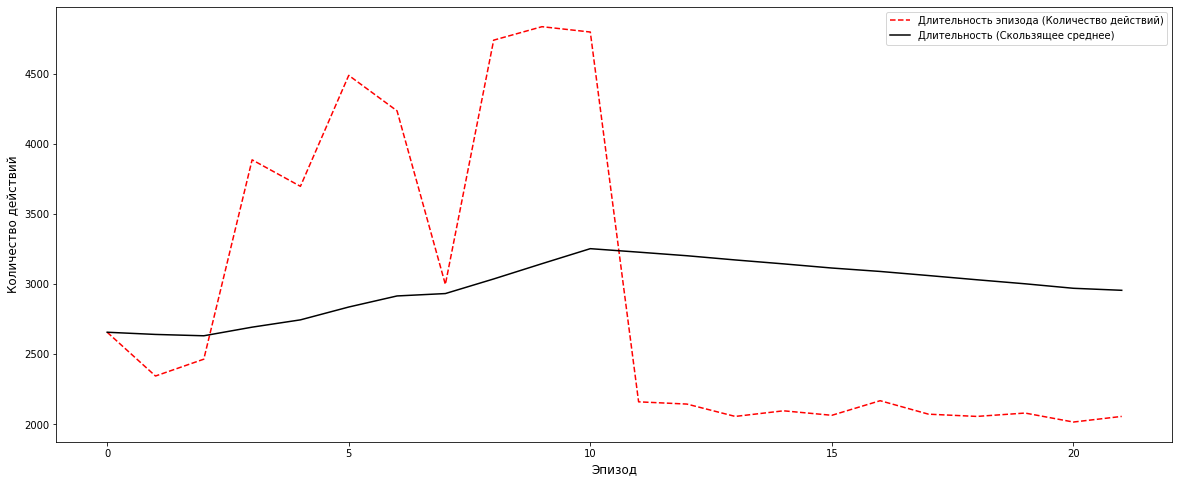

KeyboardInterrupt: ignored

In [ ]:
actor_optimizer = tf.keras.optimizers.RMSprop(learning_rate = 1e-4)   #Создаем оптимизатор RMSprop для актёра   
critic_optimizer = tf.keras.optimizers.RMSprop(learning_rate = 1e-4)  #Создаем оптимизатор RMSprop для критика   

experiment() #Прогоняем эксперимент

#Эксперимент №2 - шаг обучения критика в 10 раз больше

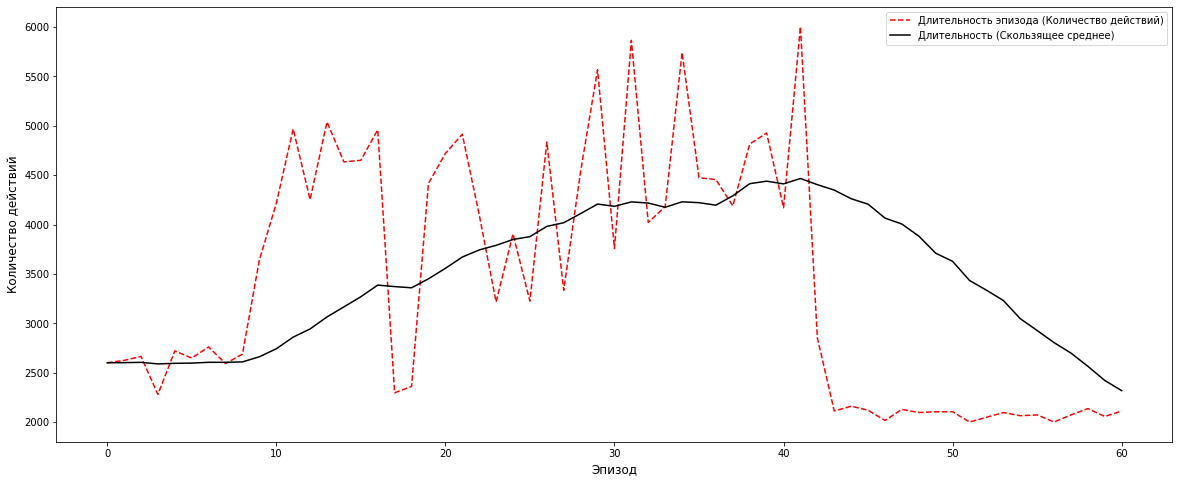

Статистика успешно сохранена.
Закончился 1220-й эпизод.
Агент продержался 384 игровых кадров
Закончился 1221-й эпизод.
Агент продержался 416 игровых кадров
Закончился 1222-й эпизод.
Агент продержался 448 игровых кадров
Закончился 1223-й эпизод.
Агент продержался 384 игровых кадров
Закончился 1224-й эпизод.
Агент продержался 384 игровых кадров
Закончился 1225-й эпизод.
Агент продержался 384 игровых кадров
Закончился 1226-й эпизод.
Агент продержался 384 игровых кадров
Закончился 1227-й эпизод.
Агент продержался 384 игровых кадров
Закончился 1228-й эпизод.
Агент продержался 384 игровых кадров
Закончился 1229-й эпизод.
Агент продержался 448 игровых кадров
Закончился 1230-й эпизод.
Агент продержался 384 игровых кадров
Закончился 1231-й эпизод.
Агент продержался 384 игровых кадров
Закончился 1232-й эпизод.
Агент продержался 384 игровых кадров
Закончился 1233-й эпизод.
Агент продержался 384 игровых кадров
Закончился 1234-й эпизод.
Агент продержался 416 игровых кадров
Закончился 1235-й эпизод.

KeyboardInterrupt: ignored

In [ ]:
actor_optimizer = tf.keras.optimizers.RMSprop(learning_rate = 1e-4)   #Создаем оптимизатор RMSprop для актёра (используем низкий шаг обучения)
critic_optimizer = tf.keras.optimizers.RMSprop(learning_rate = 1e-3)  #Создаем оптимизатор RMSprop для критика (используем высокий шаг обучения)

experiment() #Прогоняем эксперимент

Вывод - соотношение между шагами обучения актёра и критика имеет большое значение. Как мы видим, при одинаковым шаге обучения, агент не осваивает среду. При наше обучения критика в 10 раз больше есть результат, но затем агент перестает обучаться и начинает делать что-попало.

Шаг обучения критика в 2 раза выше, чем актёра (как в лекции), приводит к самому хорошему результату.

#Эксперимент №3 - меняем архитектуру сети (добавляем слои Dropout)

In [ ]:
#Создаем класс, через который будем создавать модель артёка и модель критика
#Инициализатор класса принимает на вход лишь один параметр - количество возможных действий в среде.
#Если этот параметр не задается, его значение по умолчанию будет None, что обозначает этот класс будет создавать не модель актёра, а модель критика.

class Actor_Critic(tf.keras.Model):       #Класс наследует все методы из класса tf.keras.Model - это обязательно!!!
  def __init__(self, is_actor = True):
    super().__init__()  #В первой строке при инициазизации класса нужно указать эту команду, чтобы инициализировать наследственный класс. Иначе класс не будет работать!
    self.conv_1 = Conv2D(32, 4, strides=(2, 2), activation='relu')   #Создаем первый свёрточный слой
    self.dropout_1 = SpatialDropout2D(0.2)                           #Создаем первый слой регуляризации
    self.conv_2 = Conv2D(64, 3, strides=(2, 2), activation='relu')   #Создаем второй свёрточный слой
    self.dropout_2 = SpatialDropout2D(0.2)                           #Создаем первый слой регуляризации
    self.conv_3 = Conv2D(128, 3, strides=(2, 2), activation='relu')  #Создаем третий свёрточный слой
    self.dropout_3 = SpatialDropout2D(0.2)                           #Создаем первый слой регуляризации
    self.conv_4 = Conv2D(256, 3, strides=(2, 2), activation='relu')  #Создаем третий свёрточный слой
    self.dropout_4 = SpatialDropout2D(0.2)                           #Создаем первый слой регуляризации
    self.conv_5 = Conv2D(512, 3, strides=(2, 2), activation='relu')  #Создаем третий свёрточный слой
    self.dropout_5 = SpatialDropout2D(0.2)                           #Создаем первый слой регуляризации
    self.reduce_dimension = GlobalMaxPooling2D()                     #Создаем слой для снижения размерности
    self.concatenate = Concatenate()                                 #Создаем слой конкатенации (позже объясним, зачем он нужен и как используется)
    self.dense = Dense(512, activation = 'relu')                     #Создаем второй полносвязанный слой
    if is_actor:   #Если параметр is_actor имеет соответствующее значение, мы создаем актёра.
      self.output_layer = Dense(action_size, activation = 'softmax') #Соответственно, создаем полносвязанный выходной слой с action_size количество нейронов (action_size это количество уникальных действий в среде).
    else:             #Иначе:
      self.output_layer = Dense(1) #Создаем выходной слой с 1 нейроном и линейной активационной функцией (т.е. создаем критика)
        
  #Также, нам необходимо создать метод для вызова класса. Этот метод содержит прямой проход нейронной сети,
  #то есть именно в этом методе мы определяем как слои связанны между друг-другом и как они обрабатывают данные.
  #Функция вызова принимает на вход два параметра, потому что у нейронной сети действительно будет два входа - оба которые будут принимать данные из игровой среды   
  def __call__(self, input_1, input_2):
    x = self.conv_1(input_1)     #Первый вход будет принимать массив последовательных кадров из игровой среды (как это делалось раньше) - подается в слой регуляризации.
    x = self.dropout_1(x)        #Обрабатываем данные слоем регуляризации
    x = self.conv_2(x)           #Выходной массив первого слоя подается в слой регуляризации   
    x = self.dropout_2(x)        #Обрабатываем данные слоем регуляризации
    x = self.conv_3(x)           #Выходной массив второго слоя подается в слой регуляризации
    x = self.dropout_3(x)        #Обрабатываем данные слоем регуляризации
    x = self.conv_4(x)           #Выходной массив второго слоя подается в слой регуляризации  
    x = self.dropout_4(x)        #Обрабатываем данные слоем регуляризации
    x = self.conv_5(x)           #Выходной массив второго слоя подается в слой регуляризации
    x = self.dropout_5(x)        #Обрабатываем данные слоем регуляризации
    x = self.reduce_dimension(x) #Выходной массив пятого слоя подается на выравнивающий слой 
    x = self.concatenate([x, input_2])  #Дальше делаем конкатенацию выравнивающего слоя (который содержит фичи, которые извлекли свёртки) с вторым входом, на который мы будем подавать игровые данные из среды (текущее здоровье игрока).
    x = self.dense(x)            #Результат конкатенации подаем на полносвзязанный слой
    output_data = self.output_layer(x) #Выход второго полносвязанного слоя подаем на последний слой нейронной сети (action_size нейронов если это актёр, иначе 1 нейрон)
    return output_data   #Возвращаем результат обработки нейронной сети

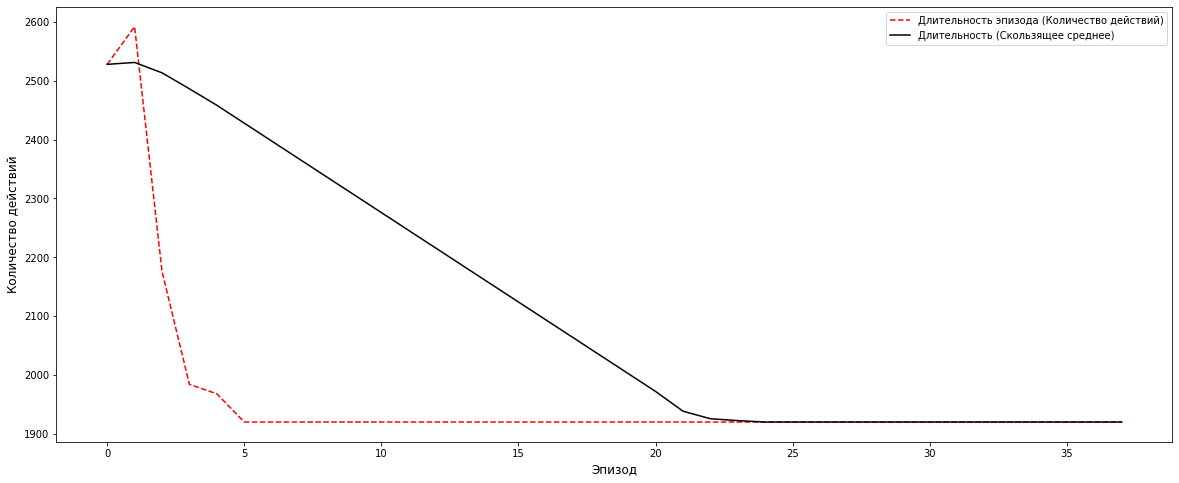

Статистика успешно сохранена.
Закончился 760-й эпизод.
Агент продержался 384 игровых кадров
Закончился 761-й эпизод.
Агент продержался 384 игровых кадров
Закончился 762-й эпизод.
Агент продержался 384 игровых кадров
Закончился 763-й эпизод.
Агент продержался 384 игровых кадров
Закончился 764-й эпизод.
Агент продержался 384 игровых кадров
Закончился 765-й эпизод.
Агент продержался 384 игровых кадров
Закончился 766-й эпизод.
Агент продержался 384 игровых кадров
Закончился 767-й эпизод.
Агент продержался 384 игровых кадров
Закончился 768-й эпизод.
Агент продержался 384 игровых кадров
Закончился 769-й эпизод.
Агент продержался 384 игровых кадров
Закончился 770-й эпизод.
Агент продержался 384 игровых кадров
Закончился 771-й эпизод.
Агент продержался 384 игровых кадров
Закончился 772-й эпизод.
Агент продержался 384 игровых кадров
Закончился 773-й эпизод.
Агент продержался 384 игровых кадров
Закончился 774-й эпизод.
Агент продержался 384 игровых кадров
Закончился 775-й эпизод.
Агент продержал

KeyboardInterrupt: ignored

In [ ]:
actor_optimizer = tf.keras.optimizers.RMSprop(learning_rate = 1e-4)   #Создаем оптимизатор RMSprop для актёра (используем низкий шаг обучения)
critic_optimizer = tf.keras.optimizers.RMSprop(learning_rate = 2e-4)  #Создаем оптимизатор RMSprop для критика (используем высокий шаг обучения)

experiment() #Прогоняем эксперимент

#Эксперимент №4 - меняем архитектуру сети (добавляем слои BatchNormalization)

In [ ]:
#Создаем класс, через который будем создавать модель артёка и модель критика
#Инициализатор класса принимает на вход лишь один параметр - количество возможных действий в среде.
#Если этот параметр не задается, его значение по умолчанию будет None, что обозначает этот класс будет создавать не модель актёра, а модель критика.

class Actor_Critic(tf.keras.Model):       #Класс наследует все методы из класса tf.keras.Model - это обязательно!!!
  def __init__(self, is_actor = True):
    super().__init__()  #В первой строке при инициазизации класса нужно указать эту команду, чтобы инициализировать наследственный класс. Иначе класс не будет работать!
    self.conv_1 = Conv2D(32, 4, strides=(2, 2), activation='relu')   #Создаем первый свёрточный слой
    self.batchnorm_1 = BatchNormalization()                           #Создаем первый слой нормализации
    self.conv_2 = Conv2D(64, 3, strides=(2, 2), activation='relu')   #Создаем второй свёрточный слой
    self.batchnorm_2 = BatchNormalization()                            #Создаем первый слой нормализации
    self.conv_3 = Conv2D(128, 3, strides=(2, 2), activation='relu')  #Создаем третий свёрточный слой
    self.batchnorm_3 = BatchNormalization()                            #Создаем первый слой нормализации
    self.conv_4 = Conv2D(256, 3, strides=(2, 2), activation='relu')  #Создаем третий свёрточный слой
    self.batchnorm_4 = BatchNormalization()                            #Создаем первый слой нормализации
    self.conv_5 = Conv2D(512, 3, strides=(2, 2), activation='relu')  #Создаем третий свёрточный слой
    self.batchnorm_5 = BatchNormalization()                            #Создаем первый слой нормализации
    self.reduce_dimension = GlobalMaxPooling2D()                     #Создаем слой для снижения размерности
    self.concatenate = Concatenate()                                 #Создаем слой конкатенации (позже объясним, зачем он нужен и как используется)
    self.dense = Dense(512, activation = 'relu')                     #Создаем второй полносвязанный слой
    if is_actor:   #Если параметр is_actor имеет соответствующее значение, мы создаем актёра.
      self.output_layer = Dense(action_size, activation = 'softmax') #Соответственно, создаем полносвязанный выходной слой с action_size количество нейронов (action_size это количество уникальных действий в среде).
    else:             #Иначе:
      self.output_layer = Dense(1) #Создаем выходной слой с 1 нейроном и линейной активационной функцией (т.е. создаем критика)
        
  #Также, нам необходимо создать метод для вызова класса. Этот метод содержит прямой проход нейронной сети,
  #то есть именно в этом методе мы определяем как слои связанны между друг-другом и как они обрабатывают данные.
  #Функция вызова принимает на вход два параметра, потому что у нейронной сети действительно будет два входа - оба которые будут принимать данные из игровой среды   
  def __call__(self, input_1, input_2):
    x = self.conv_1(input_1)     #Первый вход будет принимать массив последовательных кадров из игровой среды (как это делалось раньше) - подается в слой нормализации.
    x = self.batchnorm_1(x)        #Обрабатываем данные слоем нормализации
    x = self.conv_2(x)           #Выходной массив первого слоя подается в слой нормализации  
    x = self.batchnorm_2(x)        #Обрабатываем данные слоем нормализации
    x = self.conv_3(x)           #Выходной массив второго слоя подается в слой м
    x = self.batchnorm_3(x)        #Обрабатываем данные слоем нормализации
    x = self.conv_4(x)           #Выходной массив второго слоя подается в слой нормализации  
    x = self.batchnorm_4(x)        #Обрабатываем данные слоем нормализации
    x = self.conv_5(x)           #Выходной массив второго слоя подается в слой нормализации
    x = self.batchnorm_5(x)        #Обрабатываем данные слоем нормализации
    x = self.reduce_dimension(x) #Выходной массив пятого слоя подается на выравнивающий слой 
    x = self.concatenate([x, input_2])  #Дальше делаем конкатенацию выравнивающего слоя (который содержит фичи, которые извлекли свёртки) с вторым входом, на который мы будем подавать игровые данные из среды (текущее здоровье игрока).
    x = self.dense(x)            #Результат конкатенации подаем на полносвзязанный слой
    output_data = self.output_layer(x) #Выход второго полносвязанного слоя подаем на последний слой нейронной сети (action_size нейронов если это актёр, иначе 1 нейрон)
    return output_data   #Возвращаем результат обработки нейронной сети

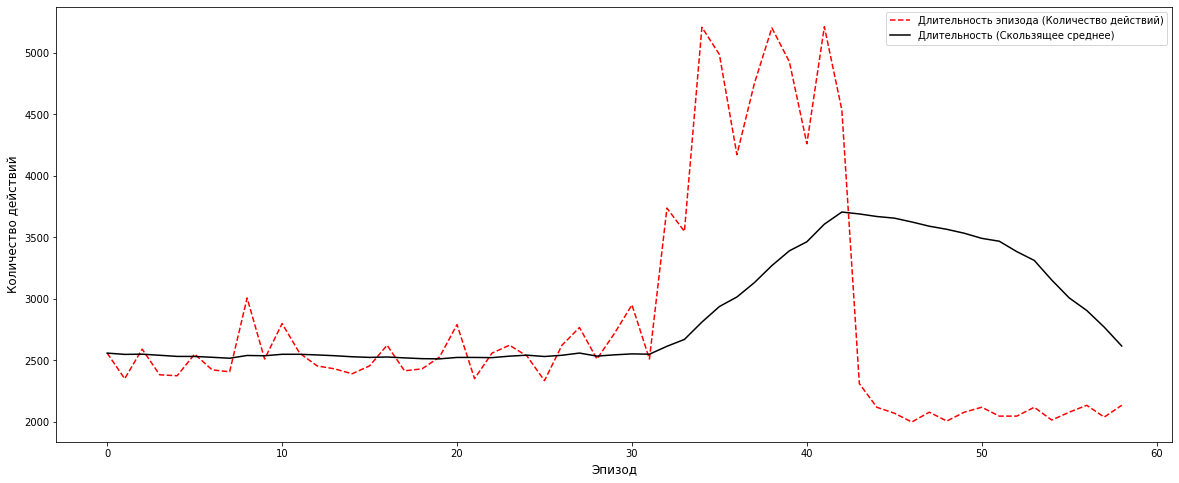

Статистика успешно сохранена.
Закончился 1180-й эпизод.
Агент продержался 384 игровых кадров
Закончился 1181-й эпизод.
Агент продержался 480 игровых кадров
Закончился 1182-й эпизод.
Агент продержался 448 игровых кадров
Закончился 1183-й эпизод.
Агент продержался 384 игровых кадров
Закончился 1184-й эпизод.
Агент продержался 416 игровых кадров
Закончился 1185-й эпизод.
Агент продержался 384 игровых кадров
Закончился 1186-й эпизод.
Агент продержался 384 игровых кадров
Закончился 1187-й эпизод.
Агент продержался 384 игровых кадров
Закончился 1188-й эпизод.
Агент продержался 448 игровых кадров
Закончился 1189-й эпизод.
Агент продержался 448 игровых кадров
Закончился 1190-й эпизод.
Агент продержался 384 игровых кадров
Закончился 1191-й эпизод.
Агент продержался 384 игровых кадров
Закончился 1192-й эпизод.
Агент продержался 448 игровых кадров
Закончился 1193-й эпизод.
Агент продержался 416 игровых кадров
Закончился 1194-й эпизод.
Агент продержался 512 игровых кадров
Закончился 1195-й эпизод.

KeyboardInterrupt: ignored

In [ ]:
actor_optimizer = tf.keras.optimizers.RMSprop(learning_rate = 1e-4)   #Создаем оптимизатор RMSprop для актёра (используем низкий шаг обучения)
critic_optimizer = tf.keras.optimizers.RMSprop(learning_rate = 2e-4)  #Создаем оптимизатор RMSprop для критика (используем высокий шаг обучения)

experiment() #Прогоняем эксперимент

Как мы видим, слои Dropout сильно ухудшают результат - сеть почти сразу теряется. В случае с BatchNormalization не так плохо, как без них.

От сюда можно сделать вывод, что слои Dropout и BatchNormalization плохо влияют на политические алгоритмы, в частности на алгоритма A2C.

# Последний "эксперимент" - повторим алгоритм лекционного ноутбука, чтобы убедится что всё работает

In [ ]:
#Создаем класс, через который будем создавать модель артёка и модель критика
#Инициализатор класса принимает на вход лишь один параметр - количество возможных действий в среде.
#Если этот параметр не задается, его значение по умолчанию будет None, что обозначает этот класс будет создавать не модель актёра, а модель критика.

class Actor_Critic(tf.keras.Model):       #Класс наследует все методы из класса tf.keras.Model - это обязательно!!!
  def __init__(self, is_actor = True):
    super().__init__()  #В первой строке при инициазизации класса нужно указать эту команду, чтобы инициализировать наследственный класс. Иначе класс не будет работать!
    self.conv_1 = Conv2D(32, 4, strides=(2, 2), activation='relu')   #Создаем первый свёрточный слой
    self.conv_2 = Conv2D(64, 3, strides=(2, 2), activation='relu')   #Создаем второй свёрточный слой
    self.conv_3 = Conv2D(128, 3, strides=(2, 2), activation='relu')  #Создаем третий свёрточный слой
    self.conv_4 = Conv2D(256, 3, strides=(2, 2), activation='relu')  #Создаем третий свёрточный слой
    self.conv_5 = Conv2D(512, 3, strides=(2, 2), activation='relu')  #Создаем третий свёрточный слой
    self.reduce_dimension = GlobalMaxPooling2D()                     #Создаем слой для снижения размерности
    self.concatenate = Concatenate()                                 #Создаем слой конкатенации (позже объясним, зачем он нужен и как используется)
    self.dense = Dense(512, activation = 'relu')                     #Создаем второй полносвязанный слой
    if is_actor:   #Если параметр is_actor имеет соответствующее значение, мы создаем актёра.
      self.output_layer = Dense(action_size, activation = 'softmax') #Соответственно, создаем полносвязанный выходной слой с action_size количество нейронов (action_size это количество уникальных действий в среде).
    else:             #Иначе:
      self.output_layer = Dense(1) #Создаем выходной слой с 1 нейроном и линейной активационной функцией (т.е. создаем критика)
        
  #Также, нам необходимо создать метод для вызова класса. Этот метод содержит прямой проход нейронной сети,
  #то есть именно в этом методе мы определяем как слои связанны между друг-другом и как они обрабатывают данные.
  #Функция вызова принимает на вход два параметра, потому что у нейронной сети действительно будет два входа - оба которые будут принимать данные из игровой среды   
  def __call__(self, input_1, input_2):
    x = self.conv_1(input_1)     #Первый вход будет принимать массив последовательных кадров из игровой среды (как это делалось раньше) - подается в слой нормализации.
    x = self.conv_2(x)           #Выходной массив первого слоя подается в свёрточный слой  
    x = self.conv_3(x)           #Выходной массив второго слоя подается в свёрточный слой  
    x = self.conv_4(x)           #Выходной массив второго слоя подается в свёрточный слой   
    x = self.conv_5(x)           #Выходной массив второго слоя подается в свёрточный слой  
    x = self.reduce_dimension(x) #Выходной массив пятого слоя подается на выравнивающий слой 
    x = self.concatenate([x, input_2])  #Дальше делаем конкатенацию выравнивающего слоя (который содержит фичи, которые извлекли свёртки) с вторым входом, на который мы будем подавать игровые данные из среды (текущее здоровье игрока).
    x = self.dense(x)            #Результат конкатенации подаем на полносвзязанный слой
    output_data = self.output_layer(x) #Выход второго полносвязанного слоя подаем на последний слой нейронной сети (action_size нейронов если это актёр, иначе 1 нейрон)
    return output_data   #Возвращаем результат обработки нейронной сети

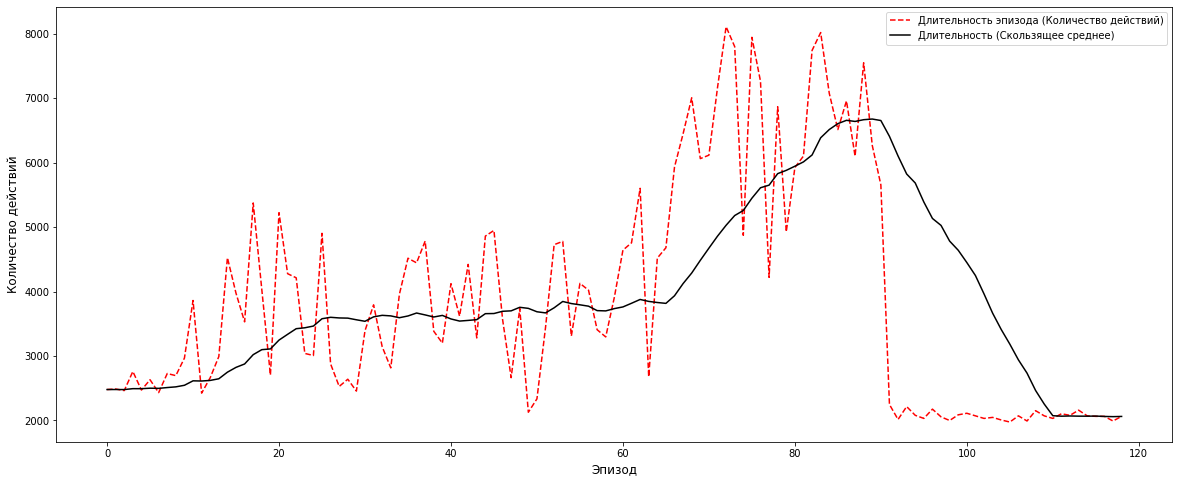

Статистика успешно сохранена.
Закончился 2380-й эпизод.
Агент продержался 384 игровых кадров
Закончился 2381-й эпизод.
Агент продержался 384 игровых кадров
Закончился 2382-й эпизод.
Агент продержался 384 игровых кадров
Закончился 2383-й эпизод.
Агент продержался 448 игровых кадров
Закончился 2384-й эпизод.
Агент продержался 384 игровых кадров
Закончился 2385-й эпизод.
Агент продержался 384 игровых кадров
Закончился 2386-й эпизод.
Агент продержался 448 игровых кадров
Закончился 2387-й эпизод.
Агент продержался 384 игровых кадров
Закончился 2388-й эпизод.
Агент продержался 384 игровых кадров


In [ ]:
actor_optimizer = tf.keras.optimizers.RMSprop(learning_rate = 1e-4)   #Создаем оптимизатор RMSprop для актёра (используем низкий шаг обучения)
critic_optimizer = tf.keras.optimizers.RMSprop(learning_rate = 2e-4)  #Создаем оптимизатор RMSprop для критика (используем высокий шаг обучения)

experiment() #Прогоняем эксперимент

Сейчас мы видим, что даже алгоритм из лекционного ноутбука может "потеряться" если он обучается слишком долго. Однако, он показывает себя лучше, чам все остальные алгоритмы. 